## 0) Setup & Imports
Upload the datasets when prompted:
1) `salary_experience.csv`
2) `Absenteeism_data.csv`

In [1]:
# (Colab) upload required CSV files
from google.colab import files
uploaded = files.upload()

import numpy as np
import pandas as pd

Saving Absenteeism_data.csv to Absenteeism_data.csv
Saving salary_experience.csv to salary_experience.csv


In [2]:
# Optional helper: keep plots working even if Arabic-shaping libs are unavailable
def fix_arabic_text(s: str) -> str:
    try:
        import arabic_reshaper
        from bidi.algorithm import get_display
        return get_display(arabic_reshaper.reshape(s))
    except Exception:
        return s

def text_arabic_fix(s: str) -> str:
    # alias used in the chapter snippets
    return fix_arabic_text(s)

## 1) Simple Linear Regression (Salary vs. Years of Experience)
### 1.1 Load data

In [3]:
import pandas as pd

salary_data = pd.read_csv("salary_experience.csv")
salary_data.head()

,YearsExperience,MonthlySalary
0,7,6962.525822
1,20,13356.240029
2,15,9677.989878
3,11,8953.532898
4,8,6961.636025


### 1.2 Check linearity visually + Pearson correlation

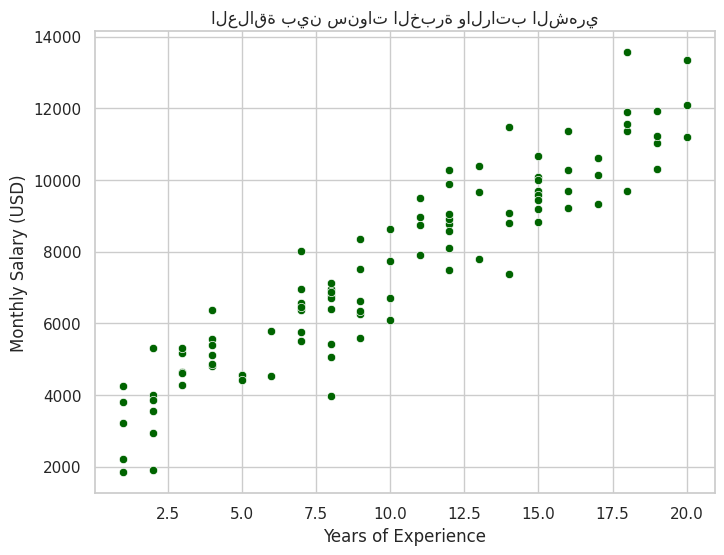

معامل ارتباط بيرسون: 0.94


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='YearsExperience', y='MonthlySalary', data=salary_data, color='darkgreen')
plt.title(text_arabic_fix('العلاقة بين سنوات الخبرة والراتب الشهري'))
plt.xlabel('Years of Experience')
plt.ylabel('Monthly Salary (USD)')
plt.show()

# Pearson correlation
correlation = salary_data[['YearsExperience', 'MonthlySalary']].corr().iloc[0, 1]
print(f"معامل ارتباط بيرسون: {correlation:.2f}")

### 1.3 Residual diagnostics (distribution, Q–Q plot, homoscedasticity check)

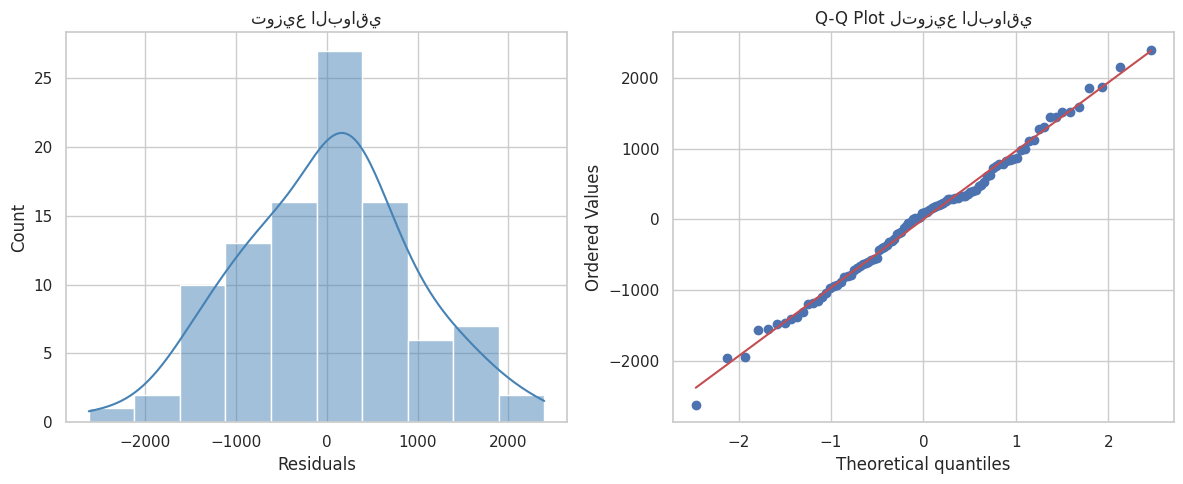

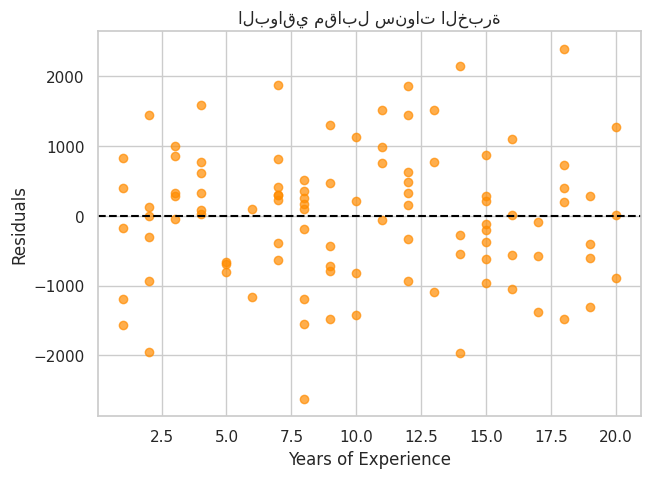

In [5]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

# Independent and dependent variables
X = salary_data[['YearsExperience']]
y = salary_data['MonthlySalary']

# Fit on full data (diagnostics-only)
model = LinearRegression()
model.fit(X, y)

# Predict and compute residuals
y_pred = model.predict(X)
residuals = y - y_pred

# Residual distribution + Q-Q plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='steelblue')
plt.title(fix_arabic_text('توزيع البواقي'))
plt.xlabel('Residuals')

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(fix_arabic_text('Q-Q Plot لتوزيع البواقي'))

plt.tight_layout()
plt.show()

# Residuals vs. independent variable
plt.figure(figsize=(7, 5))
plt.scatter(X, residuals, alpha=0.7, color='darkorange')
plt.axhline(y=0, color='black', linestyle='--')
plt.title(fix_arabic_text('البواقي مقابل سنوات الخبرة'))
plt.xlabel('Years of Experience')
plt.ylabel('Residuals')
plt.show()

### 1.4 Train–test split

In [6]:
from sklearn.model_selection import train_test_split

X = salary_data[['YearsExperience']]
y = salary_data['MonthlySalary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("حجم مجموعة التدريب:", X_train.shape)
print("حجم مجموعة الاختبار:", X_test.shape)

حجم مجموعة التدريب: (80, 1)
حجم مجموعة الاختبار: (20, 1)


### 1.5 Fit the linear model + compare actual vs. predicted

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results = pd.DataFrame({
    'YearsExperience': X_test.squeeze(),
    'ActualSalary': y_test,
    'PredictedSalary': y_pred
})

print(results.head())

    YearsExperience  ActualSalary  PredictedSalary
83               17   9329.543387     10782.156563
53                6   4531.321962      5712.460433
70               15   8830.575766      9860.393631
45                3   4275.554084      4329.816034
44               15  10007.550391      9860.393631


### 1.6 Evaluate model (MAE, RMSE, R²)

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 768.10
Root Mean Squared Error (RMSE): 1008.19
R-squared (R²): 0.82


### 1.7 Plot regression line (test points vs. predictions)

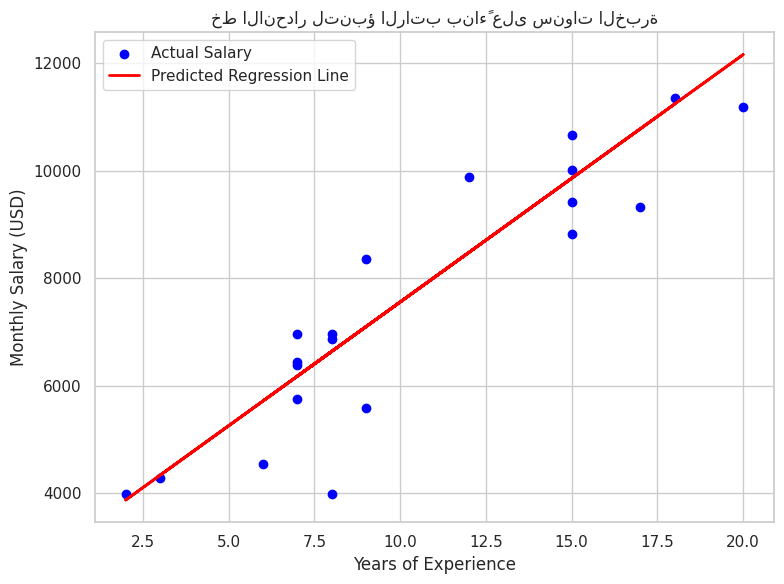

In [9]:
plt.figure(figsize=(8, 6))

plt.scatter(X_test, y_test, color='blue', label='Actual Salary')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Regression Line')

plt.title('خط الانحدار لتنبؤ الراتب بناءً على سنوات الخبرة')
plt.xlabel('Years of Experience')
plt.ylabel('Monthly Salary (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.8 Predict salary for a specific experience value

In [10]:
experience_value = 10
experience_input = [[experience_value]]

predicted_salary = model.predict(experience_input)
print(f'الراتب المتوقع لموظف لديه {experience_value} سنوات خبرة هو: {predicted_salary[0]:.2f}$')

الراتب المتوقع لموظف لديه 10 سنوات خبرة هو: 7555.99$


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### 1.9 Cross-validation (MAE across folds)

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

model = LinearRegression()
mae_scores = cross_val_score(
    model, X, y, cv=5, scoring=make_scorer(mean_absolute_error)
)

print("MAE scores from each fold:", mae_scores)
print("Average MAE:", np.mean(mae_scores))

MAE scores from each fold: [816.27905214 615.258915   784.20039868 852.263817   764.35365787]
Average MAE: 766.4711681364449


## 2) Multiple Linear Regression (Absenteeism Time in Hours)
### 2.1 Load data + define target/features

In [12]:
data = pd.read_csv("Absenteeism_data.csv")
data.head()

,ID,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,11,26,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,36,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,3,23,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,7,7,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,11,23,23/07/2015,289,36,33,239.554,30,1,2,1,2


In [13]:
target = 'Absenteeism Time in Hours'
features = [
    'Age',
    'Distance to Work',
    'Transportation Expense',
    'Daily Work Load Average',
    'Body Mass Index',
    'Children',
    'Education'
]

X = data[features]
y = data[target]

### 2.2 Check missing values

In [15]:
missing_values = data[features + [target]].isnull().sum()
print("القيم المفقودة في كل عمود:\n", missing_values)

القيم المفقودة في كل عمود:
 Age                          0
Distance to Work             0
Transportation Expense       0
Daily Work Load Average      0
Body Mass Index              0
Children                     0
Education                    0
Absenteeism Time in Hours    0
dtype: int64


### 2.3 Train–test split (80/20)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("حجم مجموعة التدريب:", X_train.shape)
print("حجم مجموعة الاختبار:", X_test.shape)

حجم مجموعة التدريب: (560, 7)
حجم مجموعة الاختبار: (140, 7)


### 2.4 Fit multiple linear regression + coefficients + intercept

In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

coefficients = pd.Series(model.coef_, index=X.columns)
print("معاملات الانحدار لكل متغير:")
print(coefficients)

print("الحد الثابت (intercept):", model.intercept_)

معاملات الانحدار لكل متغير:
Age                        0.088513
Distance to Work          -0.075873
Transportation Expense     0.003051
Daily Work Load Average   -0.003666
Body Mass Index           -0.153699
Children                   0.654276
Education                 -1.662979
dtype: float64
الحد الثابت (intercept): 11.795690058438193


### 2.5 Evaluate multiple regression model (MAE, RMSE, R²)

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 5.82
Root Mean Squared Error (RMSE): 12.49
R-squared (R²): 0.0043


### 2.6 Statistical model summary with `statsmodels` (OLS + `summary()`)

In [19]:
import statsmodels.api as sm

# Add intercept manually
X_train_sm = sm.add_constant(X_train)

model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

                                OLS Regression Results                               
Dep. Variable:     Absenteeism Time in Hours   R-squared:                       0.021
Model:                                   OLS   Adj. R-squared:                  0.008
Method:                        Least Squares   F-statistic:                     1.679
Date:                       Fri, 16 Jan 2026   Prob (F-statistic):              0.111
Time:                               12:22:03   Log-Likelihood:                -2211.7
No. Observations:                        560   AIC:                             4439.
Df Residuals:                            552   BIC:                             4474.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

## 3) Regularization (Lasso & Ridge) on the Absenteeism Regression
These examples use a `Pipeline` with `StandardScaler()` because regularization is sensitive to feature scale.

### 3.1 Lasso (L1 Regularization)

In [20]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lasso_model = make_pipeline(StandardScaler(), Lasso(alpha=0.1, random_state=42))
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Mean Absolute Error (MAE): {mae_lasso:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso:.2f}")
print(f"R-squared (R²): {r2_lasso:.2f}")

Mean Absolute Error (MAE): 5.80
Root Mean Squared Error (RMSE): 12.46
R-squared (R²): 0.01


### 3.2 Ridge (L2 Regularization) + coefficients

In [21]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42))
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Mean Absolute Error (MAE): {mae_ridge:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge:.2f}")
print(f"R-squared (R²): {r2_ridge:.2f}")

ridge_coefficients = ridge_model.named_steps['ridge'].coef_
coeff_df = pd.Series(ridge_coefficients, index=X.columns)

print("\nمعاملات الانحدار لكل متغير (Ridge):")
print(coeff_df)

Mean Absolute Error (MAE): 5.82
Root Mean Squared Error (RMSE): 12.49
R-squared (R²): 0.00

معاملات الانحدار لكل متغير (Ridge):
Age                        0.568303
Distance to Work          -1.134942
Transportation Expense     0.202015
Daily Work Load Average   -0.143322
Body Mass Index           -0.652321
Children                   0.743977
Education                 -1.088126
dtype: float64
